In [ ]:
import sys
sys.path.append("../../src")

import stochastic_benchmark as SB
import numpy as np
import os
import bootstrap
import interpolate
import stats
from utils_ws import *
import pickle

In [47]:
here = os.getcwd()
parameter_names = [
    "num_sweeps",
    "num_reads",
    "num_shots",
]  # think about whether iterations should be a parameter or not.
instance_cols = [
    "instance"
]  # indicates how instances should be grouped, default is ['instance']

## Response information
response_key = "approx_ratio"  # Column with the response
response_dir = 1  # whether we want to maximize (1) or minimize (-1), default is 1

## Optimizations informations
recover = True  # Whether we want to read dataframes when available, default is True
reduce_mem = True  # Required for proper reset_index after interpolation
smooth = True  # Whether virtual best should be monontonized, default is True



# creating stochastic benchmark object
sb = SB.stochastic_benchmark(
    parameter_names=parameter_names,
    here=here,
    instance_cols=instance_cols,
    response_key=response_key,
    reduce_mem=reduce_mem,
)


In [48]:

# Load all 20 instances from all_results.pkl
import zipfile
with zipfile.ZipFile('results.zip', 'r') as zip_ref:
    zip_ref.extractall('temp_extract')

with open('temp_extract/all_results.pkl', 'rb') as f:
    all_results = pickle.load(f)

print(f"Loaded {len(all_results)} instances: {list(all_results.keys())}")

# data contained pre-bootstrapped SA results by reads and sweeps
# results['best'], results['bestci'], results['p'], results['tts']
# extract approximation ratios and CIs for geometric schedule at reads {1, 10, 1000}
# map it to sweeps and write data frame per instance

Loaded 20 instances: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [ ]:
# Convert all 20 instances to bootstrap format
# change data frame formate as Bootstrap(bootstrap_files) wants param columns
# instance column, and metric columns       

# Load and save bootstrap results per instance (for reduce_mem mode)
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

bootstrap_files = []
from itertools import chain
sweeps = list(chain(range(1, 250, 1), range(250, 1001, 10)))

for instance_id in range(20):
    records = []
    data = all_results[instance_id]
    
    for reads in [1, 10, 1000]:
        approx_ratios = data['best']['geometric'][reads]
        approx_cis = data['bestci']['geometric'][reads]
        
        for i, sweep in enumerate(sweeps[:len(approx_ratios)]):
            ci_lower, ci_upper = approx_cis[i]
            
            records.append({
                'instance': instance_id,
                'num_sweeps': sweep,
                'num_reads': reads,
                'num_shots': 1, # because DataFrame.groupby(self, by, axis, level, as_index, sort, group_keys, observed, dropna)
                'boots': reads,
                'Key=approx_ratio': approx_ratios[i],
                'ConfInt=lower_Key=approx_ratio': ci_lower,
                'ConfInt=upper_Key=approx_ratio': ci_upper,
            })
    
    # Save per-instance file
    filename = f'checkpoints/bootstrapped_results_inst={instance_id}.pkl'
    df_inst = pd.DataFrame(records)
    df_inst.to_pickle(filename)
    bootstrap_files.append(filename)

# Set bootstrap results as list of files (for reduce_mem mode)
sb.set_Bootstrap(bootstrap_files)
print(f"Saved {len(bootstrap_files)} instance files to checkpoints/")

Saved 20 instance files to checkpoints/


In [ ]:
# Interpolation

if os.path.exists('checkpoints/interpolated_results.pkl'):
    os.remove('checkpoints/interpolated_results.pkl') # remove existing file for fresh inter

def resource_fcn(df):
    return df["boots"] * df["num_sweeps"] * df["num_reads"]

iParams = interpolate.InterpolationParameters(resource_fcn, parameters=parameter_names)
sb.run_Interpolate(iParams)

# Verify required columns before Stats
print([c for c in ['num_sweeps','num_reads','num_shots','boots','resource'] if c in sb.interp_results.columns])

KeyError: 'num_shots'

In [ ]:
# Cell for implementing without interpolation and with bootstrapping 

In [ ]:

# training.check_split_validity = False
# stats groupby Stats groups by ['num_sweeps','num_reads','num_shots','boots','resource']. 
# without reset_index(), those parameters remained in the MultiIndex, not in df.columns
train_test_split = 0.8
metrics = ["approx_ratio"]
stParams = stats.StatsParameters(metrics=metrics, stats_measures=[stats.Median()])
sb.run_Stats(stParams, train_test_split)




In [ ]:
#the virtual best baseline
sb.run_baseline()


In [ ]:
# Projection Experiments
sb.run_ProjectionExperiment("TrainingStats", None, None)
sb.run_ProjectionExperiment("TrainingResults", None, None)


In [ ]:
# Plot the performance and parameters
import plotting

plotting.monotone = True
sb.initPlotting()


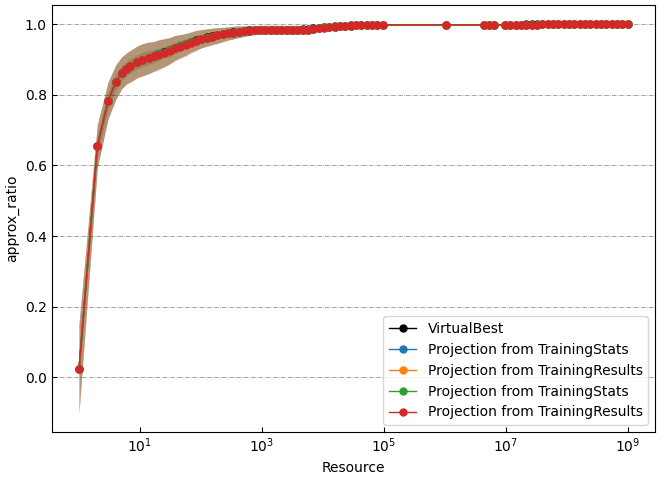

In [ ]:
fig, axs = sb.plots.plot_performance()
fig.savefig("performance.png")


  0%|          | 0/82 [00:00<?, ?it/s]

100%|██████████| 82/82 [00:00<00:00, 922.21it/s]


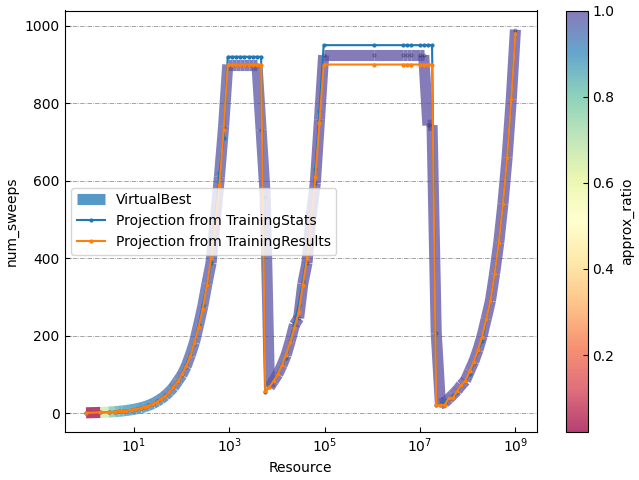

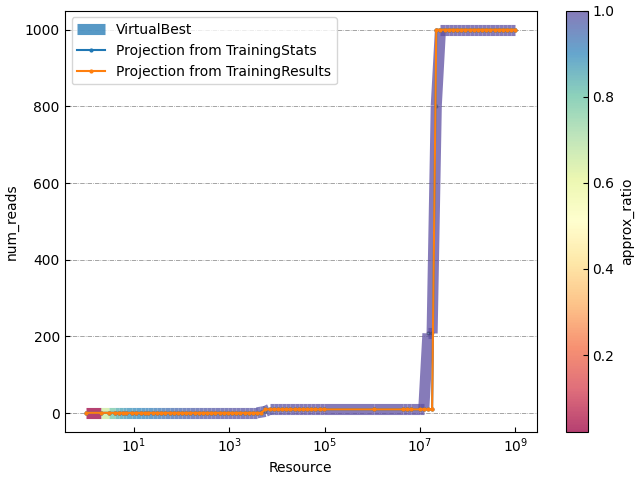

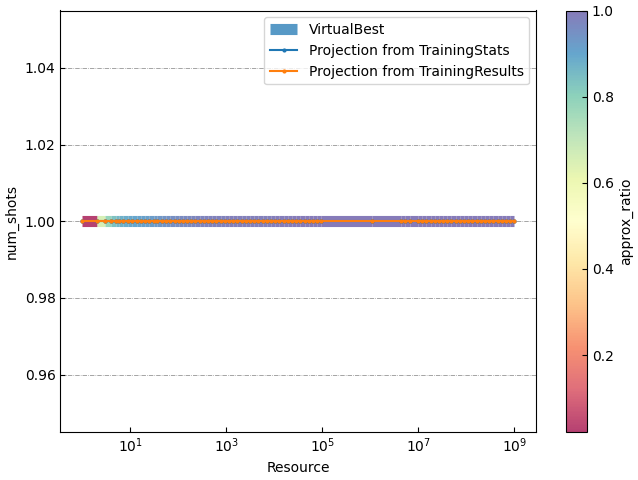

In [ ]:
figs, axes = sb.plots.plot_parameters_separate()
for param, fig in figs.items():
    fig.savefig(param + ".png")


100%|██████████| 82/82 [00:00<00:00, 970.97it/s]


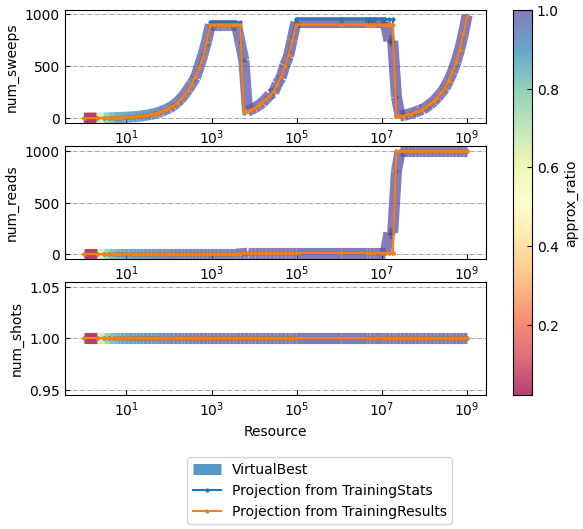

In [ ]:
fig, axes = sb.plots.plot_parameters_together()
fig.savefig("all_params.png")
